In [259]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from scipy import ndimage

In [260]:
def initU(x,y,c):
    U=np.random.rand(x,y,c)
    rsum=U.sum(axis=2)
    NU = np.divide(U,rsum[:,:, None])
    return NU

def dist_matf(data,cen,c):
    eps=0.001
    x,y = data.shape
    c = cen.shape[0]
    data1 =  np.repeat(data[:, :, None], repeats = c, axis=2)
    dist = np.zeros((x,y,c))
    repetitions = x*y
    repeats_Cen = np.tile(cen, (repetitions, 1))
    repeats_Cen = np.reshape(repeats_Cen,(x,y,c))
    dist = (data1-repeats_Cen)**2
    return dist+eps

def SNI_DIST(dist_mat,ws,c,U):
    num=U*dist_mat
    new_data=[]
    # new_datad=[]
    kernel=np.ones((ws,ws),dtype=np.float32)
    kernel[ws//2][ws//2]=0;
    for i in range(c):
        tempd=U[:,:,i]
        temp=num[:,:,i]
        temp2=ndimage.convolve(temp,kernel,mode='constant',cval=0.0)
        temp2d=ndimage.convolve(tempd,kernel,mode='constant',cval=0.0)
        temp3=temp2/temp2d
        new_data.append(temp3)
        # new_datad.append(temp2d)
    # dist_sum=np.stack(new_data,axis=2)
    # denom=np.stack(new_data,axis=2)
    # SNI=np.divide(dist_sum,denom)
    SNI=np.stack(new_data,axis=2)
    return SNI        

def updateU(dist_mat,SNI,alpha,m):
    num = (dist_mat + (SNI)*alpha)**(-1/(m-1)) #(XxYxc)
    denom=num.sum(axis=2) #(XxY)
    updatedU=num/denom[:,:,None]
    return updatedU


def SNI_dataf(data,ws,c,U):
    eps=0.001
    # repeats data for c centorids for muplticlication with membership matrix
    data_3d=np.repeat(data[:,:,None],repeats=c,axis=2) # (XxYxc)
    num=data_3d*U
    kernel=np.ones((ws,ws),dtype=np.float32)
    kernel[ws//2][ws//2]=0;
    new_data=[]
    # new_datad=[]
    for i in range(c):
        temp=num[:,:,i]
        tempd=U[:,:,i]
        temp2=ndimage.convolve(temp,kernel,mode='constant',cval=0.0)
        temp2d=ndimage.convolve(tempd,kernel,mode='constant',cval=0.0)
        temp3=temp2/temp2d
        new_data.append(temp3)
        # new_datad.append(temp2)
    # Mul=np.stack(new_data,axis=2) #(XxYxc)
    # denom=np.stack(new_datad,axis=2) #(XxYxc)
    # SNI_data=np.divide(Mul,denom+eps)
    SNI_data=np.stack(new_data,axis=2)
    return SNI_data

def updateV(data,SNI_data,alpha,mf,c):
    data_3d=np.repeat(data[:,:,None],repeats=c,axis=2)
    temp1=data_3d*mf
    temp2=alpha*(SNI_data*mf)
    num=temp1+temp2
    num_sum=num.sum(axis=1)#(Xxc)
    num_sum=num_sum.sum(axis=0)#(1xc)
    denom=mf.sum(axis=1)#(Xxc)
    denom=denom.sum(axis=0)#(1xc)
    denom=denom*(1+alpha)#(1xc)
    cen=np.divide(num_sum,denom)#(1xc)
    cen=cen.transpose()
    return cen


def obj_function(mf,dist_mat,SNI,alpha):
    obj=mf*dist_mat
    temp1=mf*SNI
    obj=obj + (alpha)*temp1
    obj_sum=obj.sum(axis=1)
    obj_sum=obj_sum.sum(axis=0)
    obj_sum=obj_sum.sum()
    return obj_sum

def FCMSNI(data,ws,alpha,m,c,epochs):
    x,y=data.shape
    Uinit=initU(x,y,c)
    U=Uinit
    obj=[]
    olddiff=0.0
    for i in range(epochs):
        mf=(U)**m
        SNI_data=SNI_dataf(data,ws,c,U)
        # print(SNI_data.shape)
        cen=updateV(data,SNI_data,alpha,mf,c)
        # print(cen.shape)
        dist_mat=dist_matf(data,cen,c)
        SNI=SNI_DIST(dist_mat,ws,c,U)
        UNew=updateU(dist_mat,SNI,alpha,m)
        objval=obj_function(mf,dist_mat,SNI,alpha)
        obj.append(objval)
        diff=((np.absolute(U-UNew)).sum(axis=1)).sum()
        print("Itteration ", i, "Differnce", diff)
        if (np.absolute(olddiff-diff)<0.01):
          break
        olddiff = diff
        U = UNew
    return U, cen, obj, dist_mat

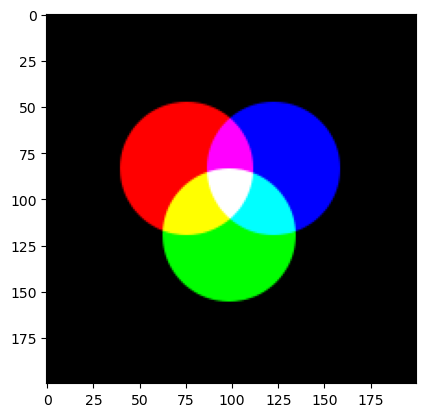

In [261]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
# testimage=img.imread('photoshop_created_image5.png')
testimage=img.imread('NewImg2_sir.jpg')
testimage2=img.imread('brain_mri.jpeg')
testimage3=img.imread('photoshop_created_image.png')
plt.imshow(testimage3,cmap='gray')
plt.show()

In [262]:
print(testimage.shape)

(875, 950)


In [263]:
# to convert to grayscale
import cv2
img_gray = cv2.cvtColor(testimage3, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [264]:
def add_gaussian_noise(image, noise_percentage):
    # Calculate standard deviation based on percentage
    max_intensity = 1
    sigma = noise_percentage * max_intensity

    # Generate Gaussian noise
    gaussian_noise = np.random.normal(0, sigma, image.shape)
    
    # Add noise to the image
    noisy_image = image + gaussian_noise
    
    # Clip values to ensure they remain in the valid range
    noisy_image = np.clip(noisy_image, 0, 1).astype(np.float32)
    
    return noisy_image

# Set the noise level (e.g., 10% of the maximum intensity)

# Apply Gaussian noise
noisy_image = add_gaussian_noise(img_gray, 0.03)


In [265]:
# plt.hist(img_gray,bins=255)

In [266]:
# plt.hist(noisy_image,bins=255)

In [267]:
print(noisy_image.shape)

(200, 200)


In [268]:
print(noisy_image)

[[0.00182709 0.0054813  0.         ... 0.02179791 0.         0.04577161]
 [0.         0.         0.         ... 0.         0.         0.02036388]
 [0.00105798 0.01185086 0.01471135 ... 0.04481968 0.01178434 0.        ]
 ...
 [0.03258283 0.03723764 0.02636328 ... 0.         0.         0.0023048 ]
 [0.0267501  0.06774215 0.         ... 0.0019641  0.00871703 0.        ]
 [0.         0.07114135 0.03122472 ... 0.02227805 0.03598057 0.0215722 ]]


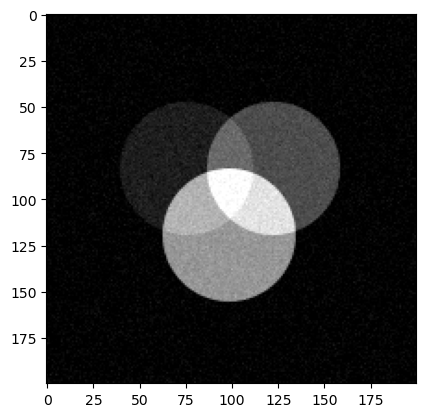

In [269]:
plt.imshow(noisy_image,cmap='gray')
plt.show()

In [270]:
print(np.unique(img_gray))

[0.         0.00134118 0.00178824 0.00223529 0.00268235 0.00351765
 0.00357647 0.00402353 0.00447059 0.0046902  0.00586274 0.00670588
 0.00703529 0.0076     0.00920784 0.00938039 0.01055294 0.0115098
 0.01162353 0.01172549 0.01296471 0.01341176 0.01381177 0.01698824
 0.0174353  0.01758824 0.01841569 0.01993333 0.02071765 0.0228
 0.02301961 0.02414118 0.02682353 0.02727059 0.02905883 0.02950588
 0.03048627 0.03129412 0.03400392 0.03452941 0.03517647 0.038
 0.03844706 0.03913334 0.04068235 0.04157647 0.04247059 0.04291765
 0.04381176 0.04455686 0.04515294 0.0456     0.04572941 0.04917647
 0.05096471 0.05141177 0.05543529 0.05588235 0.05632941 0.05677647
 0.0598     0.05985098 0.06124706 0.06331765 0.06527059 0.06661177
 0.06705882 0.06905883 0.07035294 0.07136079 0.07152549 0.07621569
 0.07738824 0.0782353  0.07912941 0.08091765 0.08207843 0.08225883
 0.08270589 0.08325098 0.08628236 0.08672941 0.08717647 0.08977648
 0.09298824 0.09388235 0.09432941 0.09477647 0.09522353 0.09745882
 0.10

In [271]:
print(np.unique(noisy_image))

[0.0000000e+00 1.5015836e-06 2.7023523e-06 ... 9.9955511e-01 9.9988461e-01
 1.0000000e+00]


In [272]:
data=noisy_image
m=2
epochs=500
ws=3
alpha=5
c=4
U,Cen,OBJ,Dist_Mat=FCMSNI(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 18195.166931255873
Itteration  1 Differnce 2107.448544138807
Itteration  2 Differnce 4630.293232453352
Itteration  3 Differnce 15980.677718948307
Itteration  4 Differnce 22512.473906974323
Itteration  5 Differnce 7459.522195226408
Itteration  6 Differnce 2164.7144679306357
Itteration  7 Differnce 2285.150853884324
Itteration  8 Differnce 1896.9897521822577
Itteration  9 Differnce 1284.3727086297395
Itteration  10 Differnce 1001.7667700482239
Itteration  11 Differnce 924.5113715286593
Itteration  12 Differnce 973.459803156132
Itteration  13 Differnce 1147.675278769712
Itteration  14 Differnce 1498.6127823133365
Itteration  15 Differnce 2134.799427463856
Itteration  16 Differnce 3179.146652224595
Itteration  17 Differnce 4382.262392688104
Itteration  18 Differnce 4403.658051980561
Itteration  19 Differnce 2708.0296462689153
Itteration  20 Differnce 1257.948964562776
Itteration  21 Differnce 577.0053537842605
Itteration  22 Differnce 270.0837215566055
Itteration  2

In [273]:
# print(U)

In [274]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)

(200, 200, 4)


In [276]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCMSNI')

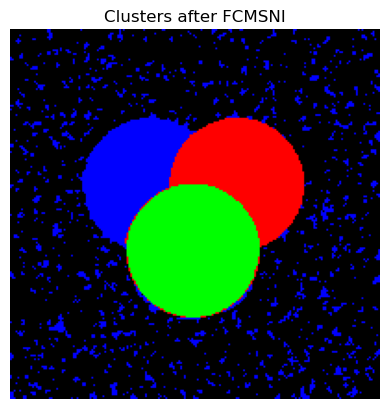

In [277]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCMSNI')

In [278]:
print(np.unique(seg1))

[0. 1.]


In [279]:
print(seg1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


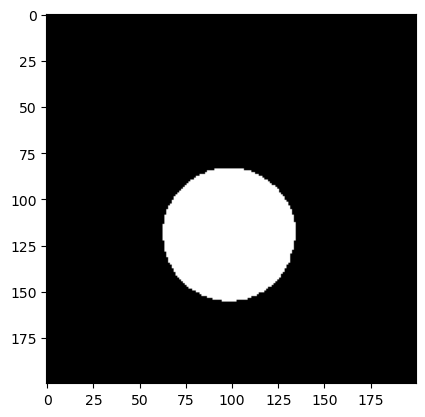

In [280]:
plt.imshow(seg2,cmap='gray')

[]

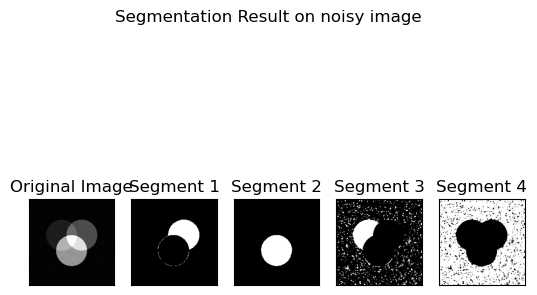

In [281]:
fig, axs = plt.subplots(1,c+1)
fig.suptitle('Segmentation Result on noisy image')
axs[0].imshow(data,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

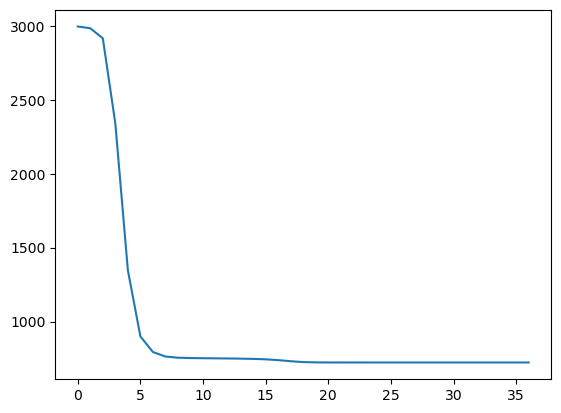

In [282]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(OBJ)

In [283]:
data=img_gray
m=2
epochs=500
ws=3
alpha=0.01
c=4
U,Cen,OBJ,Dist_Mat=FCMSNI(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 18102.20986425716
Itteration  1 Differnce 1661.474051896525
Itteration  2 Differnce 5574.914529978784
Itteration  3 Differnce 14865.481553134367
Itteration  4 Differnce 16072.757529874503
Itteration  5 Differnce 6515.759368232875
Itteration  6 Differnce 2976.1755857453845
Itteration  7 Differnce 1397.0185075552217
Itteration  8 Differnce 561.6313489719194
Itteration  9 Differnce 242.08169790576525
Itteration  10 Differnce 121.11155486068215
Itteration  11 Differnce 65.12092224156372
Itteration  12 Differnce 37.44859190449132
Itteration  13 Differnce 22.3245943745775
Itteration  14 Differnce 13.668235450022511
Itteration  15 Differnce 8.52642228050561
Itteration  16 Differnce 5.385998207906798
Itteration  17 Differnce 3.4300922150647
Itteration  18 Differnce 2.203971336236952
Itteration  19 Differnce 1.4222810257266754
Itteration  20 Differnce 0.9180117424768529
Itteration  21 Differnce 0.5926057609556137
Itteration  22 Differnce 0.38257756437324947
Itteration  2

In [284]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)

(200, 200, 4)


In [286]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

[]

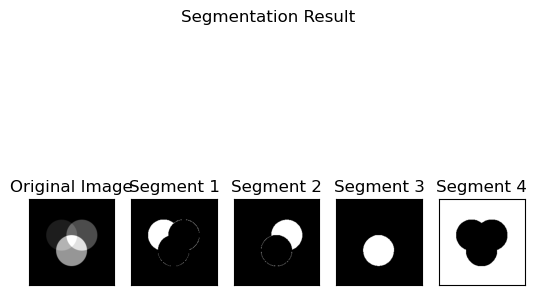

In [287]:
fig, axs = plt.subplots(1,c+1)
fig.suptitle('Segmentation Result')
axs[0].imshow(data,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

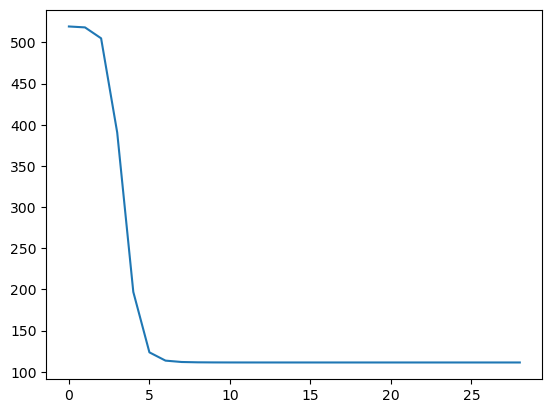

In [288]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(OBJ)

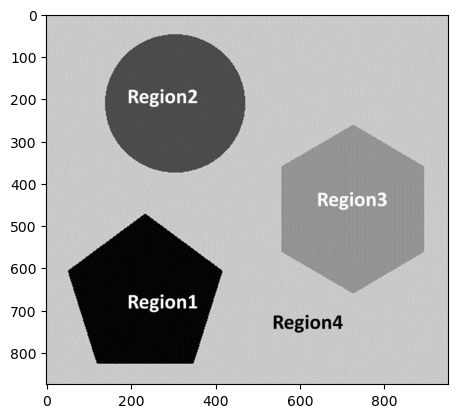

In [289]:
plt.imshow(testimage,cmap='gray')
plt.show()

In [290]:
data=testimage
m=2
epochs=500
ws=3
alpha=1
c=4
U,Cen,OBJ,Dist_Mat=FCMSNI(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 376604.260787238
Itteration  1 Differnce 16181.523526862755
Itteration  2 Differnce 22568.439870384427
Itteration  3 Differnce 93922.91906601007
Itteration  4 Differnce 300862.68575779593
Itteration  5 Differnce 644749.5846412486
Itteration  6 Differnce 210770.8021260937
Itteration  7 Differnce 151732.33648572495
Itteration  8 Differnce 113610.44746310472
Itteration  9 Differnce 7234.872547282439
Itteration  10 Differnce 523.5205552488651
Itteration  11 Differnce 89.61371643942182
Itteration  12 Differnce 30.50605656133877
Itteration  13 Differnce 10.823091129645917
Itteration  14 Differnce 4.783622428213352
Itteration  15 Differnce 2.189525057419157
Itteration  16 Differnce 1.09190456140092
Itteration  17 Differnce 0.552658551210011
Itteration  18 Differnce 0.29279324652424926
Itteration  19 Differnce 0.1560249250956221
Itteration  20 Differnce 0.08574450896541341
Itteration  21 Differnce 0.04723469163966877
Itteration  22 Differnce 0.026624825443398708
Itterat

In [291]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)

(875, 950, 4)


In [292]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCMSNI')

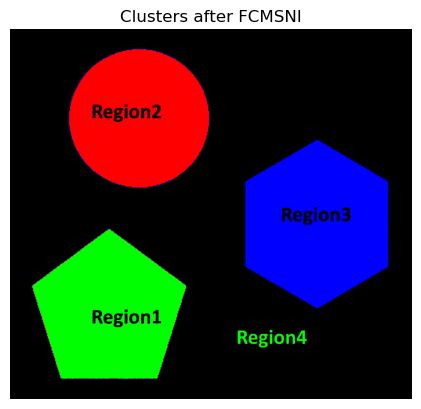

In [293]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCMSNI')

[]

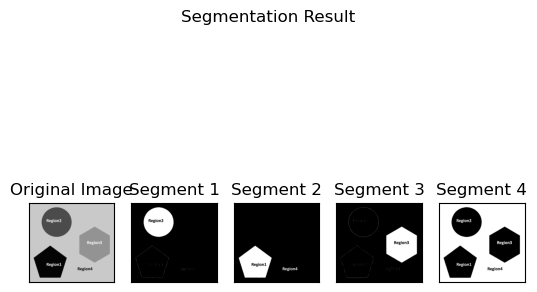

In [294]:
fig, axs = plt.subplots(1,c+1)
fig.suptitle('Segmentation Result')
axs[0].imshow(data,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

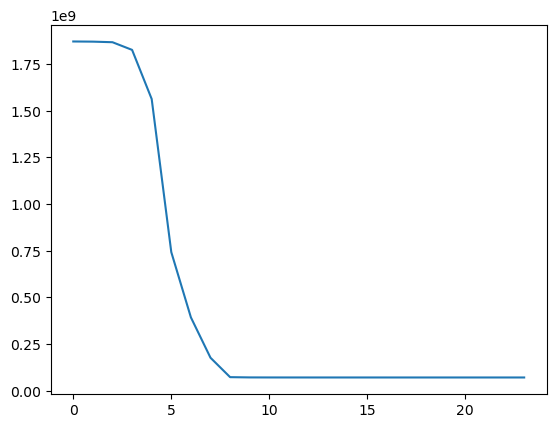

In [295]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(OBJ)

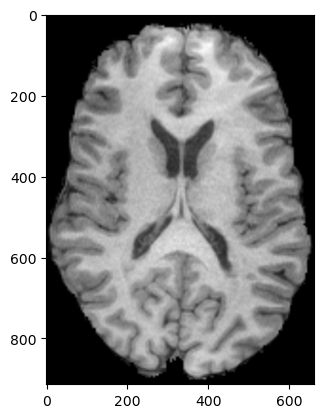

In [296]:
plt.imshow(testimage2,cmap='gray')
plt.show()

In [297]:
print(testimage2.shape)

(914, 662, 3)


In [298]:
# to convert to grayscale
import cv2
img_gray = cv2.cvtColor(testimage2, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [299]:
data=img_gray
m=2
epochs=500
ws=3
alpha=1
c=4
U,Cen,OBJ,Dist_Mat=FCMSNI(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 274502.59232482454
Itteration  1 Differnce 11442.911153516865
Itteration  2 Differnce 15721.881420422256
Itteration  3 Differnce 57337.38955453598
Itteration  4 Differnce 169962.11730054487
Itteration  5 Differnce 294003.58863900765
Itteration  6 Differnce 307987.42007353005
Itteration  7 Differnce 174366.35824444742
Itteration  8 Differnce 125534.26669339338
Itteration  9 Differnce 85102.32046174814
Itteration  10 Differnce 47203.32944383273
Itteration  11 Differnce 37366.34061191758
Itteration  12 Differnce 28926.795779290198
Itteration  13 Differnce 22505.875029904477
Itteration  14 Differnce 17599.06797435826
Itteration  15 Differnce 13915.127944401242
Itteration  16 Differnce 11138.470154648163
Itteration  17 Differnce 9016.023514232991
Itteration  18 Differnce 7365.205254195782
Itteration  19 Differnce 6060.263564045001
Itteration  20 Differnce 5014.316895779528
Itteration  21 Differnce 4166.820333006292
Itteration  22 Differnce 3474.012567517176
Itteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(914, 662, 4)


Text(0.5, 1.0, 'Clusters after FCMSNI')

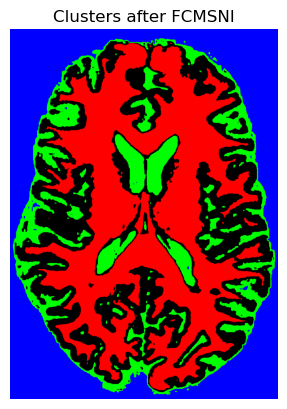

In [300]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCMSNI')

In [301]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

[]

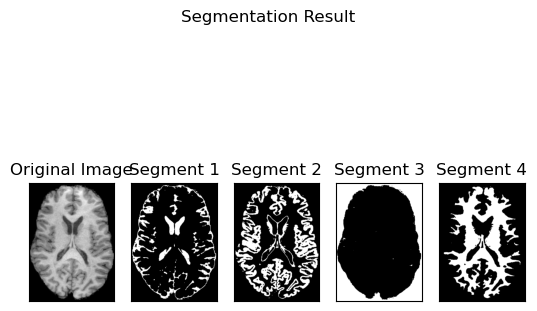

In [302]:
fig, axs = plt.subplots(1,c+1)
fig.suptitle('Segmentation Result')
axs[0].imshow(data,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])